In [1]:
expected_params = {
    "130m": 134217728,    # 32 * (512*2048*3 + 512*512*4)
    "300m": 301989888,    # 32 * (768*3072*3 + 768*768*4)
    "520m": 536870912,    # 32 * (1024*4096*3 + 1024*1024*4)
    "1.2b": 1207959552,   # 32 * (1536*6144*3 + 1536*1536*4)
}


In [1]:
import wandb
import copy
# Initialize the WandB API
api = wandb.Api()
# Define your details
username = "stanford-mercury"
project = "optimizer-scaling"
thshold = 3e-3
# Retrieve the run directly using its full path
def convert_run_to_config(run, keys):
    if 'optimizer' not in run.config or 'trainer' not in run.config:
        # too early
        return None
    return {key: run.config['optimizer'][key] if (key != 'train_batch_size') else run.config['trainer'][key] for key in keys}


def grab_best_run(keys, tags):
    filters = {"tags": {"$all": tags}}
    runs = api.runs(f"{username}/{project}", filters=filters)
    min_loss = 10000
    min_run = None
    for run in runs:
        if 'trainer' not in run.config:
            continue
        batch_size = run.config['trainer']['train_batch_size']
        loss = run.summary.get('eval/paloma/c4_en/loss', None)
        if type(loss) is float and loss < min_loss:
            min_loss = loss
            min_run = run
    approximate_min_runs = []
    for run in runs:
        loss = run.summary.get('eval/paloma/c4_en/loss', None)
        if 'trainer' not in run.config:
            continue
        batch_size = run.config['trainer']['train_batch_size']
        if type(loss) is float and loss < min_loss + thshold:
            approximate_min_runs.append(run)
    best_config = {}
    if min_run is not None: 
        best_config = convert_run_to_config(min_run, keys)
        approximate_best_list = []
        for run in approximate_min_runs:
            approximate_best_list.append(convert_run_to_config(run, keys))
        return min_loss, best_config, approximate_best_list
    else: 
        return None, None, None
    

def bad_number(x):
    return (type(x) is not float) or (x > 10000)


def bad_run(run):
    history = run.history(keys=['eval/paloma/c4_en/loss'], pandas=True)
    step = run.config['trainer']['num_train_steps']
    if(len(history) > 0):
        history = history.fillna(20)
        max_step = history['_step'].max()
        min_loss = history['eval/paloma/c4_en/loss'].min()
        if(max_step >= 2000 and min_loss >= 6):
            return True
    return False    
    

def actually_finish(run, strict = False):
    if strict:
        key = 'lm_eval/wsc273/acc'
    else:
        key = 'eval/paloma/c4_en/loss'
    history = run.history(keys=[key], pandas=True)
    step = run.config['trainer']['num_train_steps']
    if(len(history) > 0):
        max_step = history['_step'].max()
        if(max_step >= step - 10):
            return True
    return False

def approximate(baseline, config):
    if config is None:
        return False
    for key in baseline:
        if(type(baseline[key]) is not float):
            if(baseline[key] != config[key]):
                return False
        else:
            if(abs(baseline[key] - config[key]) > 1e-25):
                return False
    return True
def check_baseline_run(baseline, tags, strict = True):    
    filters = {"tags": {"$all": tags}}
    runs = api.runs(f"{username}/{project}", filters=filters)
    for run in runs:
        config = convert_run_to_config(run, baseline.keys())
        if approximate(baseline, config) and  (bad_number(run.summary.get('eval/paloma/c4_en/loss', 0.0)) or actually_finish(run, strict = strict) or bad_run(run)):
            # diverge before finish
            # or have some crazyness: finished eval multiple time
            return True
    return False


def create_configs(baseline_config, sweep_grids, target_data = 5120000):
    config_in_dict = []
    target_steps = []
    batch_size = (baseline_config['train_batch_size'])
    target_step  = target_data // (4096 * batch_size)
    target_steps.append(target_step)
    config_in_dict.append(baseline_config)
    for key in sweep_grids:
        for value in sweep_grids[key]:
            new_config = copy.copy(baseline_config)     
            if(baseline_config[key] != (value)):   
                new_config[key] = (value)
                batch_size = (new_config['train_batch_size'])
                target_step  = target_data // (4096 * batch_size)
                target_steps.append(target_step)
                if (new_config['warmup']) <= target_step:
                    config_in_dict.append(new_config)
    return target_steps, config_in_dict


d:\miniconda\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
key_of_optimizer = dict()
key_of_optimizer['mars'] = ['learning_rate', 'weight_decay', 'min_lr_ratio', 'warmup', 'beta1', 'beta2', 'gamma', 'epsilon', 'max_grad_norm', 'train_batch_size']
key_of_optimizer['muon'] = ['learning_rate', 'weight_decay', 'min_lr_ratio', 'warmup', 'momentum', 'beta1', 'beta2', 'epsilon', 'muon_epsilon', 'max_grad_norm', 'lr_schedule', 'muon_to_adam_lr', 'decay', 'train_batch_size']
key_of_optimizer['lion'] = ['learning_rate', 'weight_decay', 'min_lr_ratio', 'warmup', 'beta1', 'beta2', 'max_grad_norm', 'train_batch_size']
key_of_optimizer['nadamw'] = ['learning_rate', 'weight_decay', 'min_lr_ratio', 'warmup', 'beta1', 'beta2', 'epsilon', 'max_grad_norm', 'nesterov', 'train_batch_size']
key_of_optimizer['kron'] = ['learning_rate', 'weight_decay', 'beta1', 'preconditioner_lr', 'preconditioner_init_scale', 'max_grad_norm', 'normalize_grads', 'partition_grads_into_blocks', 'block_size', 'preconditioner_update_probability', 'update_prob_flat_start', 'warmup', 'min_lr_ratio', 'train_batch_size']
key_of_optimizer['scion'] = ['learning_rate', 'weight_decay', 'min_lr_ratio', 'warmup', 'momentum', 'beta1', 'scion_epsilon', 'max_grad_norm', 'lr_schedule', 'scion_to_signum_lr', 'decay', 'train_batch_size']
key_of_optimizer['cautious'] = ['learning_rate', 'weight_decay', 'min_lr_ratio', 'warmup', 'beta1', 'beta2', 'epsilon', 'max_grad_norm', 'train_batch_size']
key_of_optimizer['soap'] = ['learning_rate', 'weight_decay', 'min_lr_ratio', 'warmup', 'beta1', 'beta2', 'shampoo_beta', 'precondition_frequency', 'partition_grads_into_blocks', 'block_size', 'epsilon', 'max_grad_norm', 'train_batch_size']
# key_of_optimizer['sophia'] = ['learning_rate', 'weight_decay', 'min_lr_ratio', 'warmup', 'beta1', 'beta2', 'gamma', 'epsilon', 'max_grad_norm', 'train_batch_size']
key_of_optimizer['soape'] = key_of_optimizer['soap']
key_of_optimizer['soapb'] = key_of_optimizer['soap']
key_of_optimizer['adamw'] = ['learning_rate', 'weight_decay', 'min_lr_ratio', 'warmup', 'beta1', 'beta2', 'epsilon', 'max_grad_norm', 'nesterov', 'train_batch_size']
# key_of_optimizer['scion'] = key_of_optimizer['muon']



In [3]:
left_dict = {}
losses = {}
configs = {}
for model_size, data_size in [('130m', '2B'), ('130m', '5B'), ('130m', '10B'), ('130m', '21B'), ('300m', '6B'), ('520m', '10B')]:
    for optimizer in key_of_optimizer:
        print(optimizer, model_size, data_size)
        optimizer_keys = key_of_optimizer[optimizer]
        loss, best_config, approximate_best_configs = grab_best_run(optimizer_keys, [optimizer, model_size, data_size])
        losses[(optimizer, model_size, data_size)] = loss
        configs [(optimizer, model_size, data_size)] = best_config
        print(f"Best loss: {loss}")
        
# model_size = '300m'
# for data_size in ['6B']:
#     for optimizer in key_of_optimizer:
#         print(optimizer, data_size)
#         optimizer_keys = key_of_optimizer[optimizer]
#         loss, best_config, approximate_best_configs = grab_best_run(optimizer_keys, [optimizer, model_size, data_size])
#         losses[(optimizer, model_size, data_size)] = loss
#         configs [(optimizer, model_size, data_size)] = best_config
#         print(f"Best loss: {loss}")
# model_size = '520m'
# for data_size in ['10B']:
#     for optimizer in ['adamw', 'muon', 'soape', 'cautious', 'scion']:
#         print(optimizer, data_size)
#         optimizer_keys = key_of_optimizer[optimizer]
#         loss, best_config, approximate_best_configs = grab_best_run(optimizer_keys, [optimizer, model_size, data_size])
#         losses[(optimizer, model_size, data_size)] = loss
#         configs [(optimizer, model_size, data_size)] = best_config
#         print(f"Best loss: {loss}")

mars 130m 2B
Best loss: 3.536329746246338
muon 130m 2B
Best loss: 3.4626309871673584
lion 130m 2B
Best loss: 3.549180746078491
nadamw 130m 2B
Best loss: 3.5311388969421387
kron 130m 2B
Best loss: 3.4907355308532715
scion 130m 2B
Best loss: 3.4737958908081055
cautious 130m 2B
Best loss: 3.532454490661621
soap 130m 2B
Best loss: 3.4821648597717285
soape 130m 2B
Best loss: None
soapb 130m 2B
Best loss: 3.4821648597717285
adamw 130m 2B
Best loss: 3.5291428565979004
mars 130m 5B
Best loss: 3.394932270050049
muon 130m 5B
Best loss: 3.369025468826294
lion 130m 5B
Best loss: 3.4087886810302734
nadamw 130m 5B
Best loss: 3.393378496170044
kron 130m 5B
Best loss: 3.388023376464844
scion 130m 5B
Best loss: 3.377504587173462
cautious 130m 5B
Best loss: 3.4009084701538086
soap 130m 5B
Best loss: 3.374239921569824
soape 130m 5B
Best loss: None
soapb 130m 5B
Best loss: None
adamw 130m 5B
Best loss: 3.4077868461608887
mars 130m 10B
Best loss: 3.320751428604126
muon 130m 10B
Best loss: 3.294672250747680

In [4]:

# Merge soap, soapb, soape
for key in losses:
    if key[0] in ['soapb', 'soape', 'soap']:
        if losses[key] is not None:
            baseline = losses.get(('soap', key[1], key[2]), 10000)
            if baseline is not None:
                losses[('soap', key[1], key[2])] = min(losses[key], baseline)
                configs[('soap', key[1], key[2])] = configs[key]
                print(losses[('soap', key[1], key[2])])
            else:
                losses[('soap', key[1], key[2])] = losses[key]
                configs[('soap', key[1], key[2])] = configs[key]                

# delete soapb, soape
# avoid RuntimeError: dictionary changed size during iteration
keys = list(losses.keys())
for key in keys:
    if key[0] in ['soapb', 'soape']:
        del losses[key]
        del configs[key]


3.4821648597717285
3.4821648597717285
3.374239921569824
3.294482469558716
3.294482469558716
3.2374308109283447
3.2374308109283447
5.4366679191589355
3.230889797210694
3.230889797210694


In [31]:
losses[('soap','520m','10B')] = losses[('soape','520m','10B')]


In [11]:
# print AdamW config in (130M, 2B), (130M, 5B), (300M, 6B)
print("AdamW 130M 2B:", configs[('adamw', '130m', '2B')])
print("AdamW 130M 5B:", configs[('adamw', '520m', '10B')])
print("AdamW 300M 6B:", configs[('adamw', '300m', '6B')])

# implement this
'''
We will perform sweeping for two kinds of models & data (N & D)
C = N / D = 20
N = N_0 = 130M
When people fit scaling law for hyperparameter $\gamma$, a common practice is to use the following form $\gamma(N, D) = \alpha + \beta N^{-A} D^{-B}$
Typically we can decide $\alpha$ based on our prior when we train a super large model with super large amount of data
For most hyperparameters like learning rate, $\epsilon$, $\alpha = 0$
For moving average ratio $\beta_1$ and $\beta_2$, a more natural choice is $\alpha = 1$
The scaling form gives us the following equation $(\gamma(N_1, D_1) - \alpha) (\gamma(N_2, D_2) - \alpha) =(\gamma(N_3, D_3) - \alpha) (\gamma(N_4, D_4) - \alpha) $ whenever $N_1N_2 = N_3N_4$ and $D_1D_2 = D_3D_4$.
We can then [perform hyperextrapolation by defining $f(N, D) = \gamma(N,D) - \alpha$
$f(k_N N_0, k_D k_N C N_0) = f(k_N N_0, k_N C N_0)  f(N_0, k_DCN_0) / f(N_0, CN_0) $.
'''

alpha_dict = {'learning_rate': 0, 'weight_decay': 0, 'min_lr_ratio': 0, 'warmup': 0, 'beta1': 1, 'beta2': 1, 'epsilon': 0, 'max_grad_norm': 0, 'nesterov': False, 'train_batch_size': 0}

target_config = {}

for key in alpha_dict:
    alpha = alpha_dict[key]
    real_value = {}
    for config_key in [('adamw', '130m', '2B'), ('adamw', '520m', '10B'), ('adamw', '300m', '6B')]:
        real_value[config_key] = configs[config_key][key] - alpha 
    print(key)
    print(real_value[('adamw', '520m', '10B')] * real_value[('adamw', '300m', '6B')] / (real_value[('adamw', '130m', '2B')] + 1e-30) + alpha)
    target_config[key] = real_value[('adamw', '520m', '10B')] * real_value[('adamw', '300m', '6B')] / (real_value[('adamw', '130m', '2B')] + 1e-30) + alpha
print(target_config)

AdamW 130M 2B: {'learning_rate': 0.008, 'weight_decay': 0.1, 'min_lr_ratio': 0, 'warmup': 2000, 'beta1': 0.9, 'beta2': 0.98, 'epsilon': 9.999999999999999e-26, 'max_grad_norm': 1, 'nesterov': False, 'train_batch_size': 128}
AdamW 130M 5B: {'learning_rate': 0.004, 'weight_decay': 0.2, 'min_lr_ratio': 0, 'warmup': 1000, 'beta1': 0.9, 'beta2': 0.98, 'epsilon': 1e-10, 'max_grad_norm': 1, 'nesterov': False, 'train_batch_size': 256}
AdamW 300M 6B: {'learning_rate': 0.008, 'weight_decay': 0.1, 'min_lr_ratio': 0, 'warmup': 2000, 'beta1': 0.9, 'beta2': 0.98, 'epsilon': 1e-10, 'max_grad_norm': 2, 'nesterov': False, 'train_batch_size': 128}
learning_rate
0.004
weight_decay
0.20000000000000004
min_lr_ratio
0.0
warmup
1000.0
beta1
0.9
beta2
0.98
epsilon
99999.00000999992
max_grad_norm
2.0
nesterov
0.0
train_batch_size
256.0
{'learning_rate': 0.004, 'weight_decay': 0.20000000000000004, 'min_lr_ratio': 0.0, 'warmup': 1000.0, 'beta1': 0.9, 'beta2': 0.98, 'epsilon': 99999.00000999992, 'max_grad_norm': 2

In [9]:
import torch
torch.save(losses, 'losses.pt')
torch.save(configs, 'configs.pt')

In [19]:
import wandb
import copy
# Initialize the WandB API
api = wandb.Api()
# Define your details
username = "stanford-mercury"
project = "marin-optimizer"
thshold = 3e-3
# Retrieve the run directly using its full path
def convert_run_to_config(run, keys):
    if 'optimizer' not in run.config or 'trainer' not in run.config:
        # too early
        return None
    return {key: run.config['optimizer'][key] if (key != 'train_batch_size') else run.config['trainer'][key] for key in keys}


def grab_best_run(keys, tags):
    filters = {"tags": {"$all": tags}}
    runs = api.runs(f"{username}/{project}", filters=filters)
    min_loss = 10000
    min_run = None
    for run in runs:
        if 'trainer' not in run.config:
            continue
        batch_size = run.config['trainer']['train_batch_size']
        loss = run.summary.get('eval/paloma/c4_en/loss', None)
        if type(loss) is float and loss < min_loss:
            min_loss = loss
            min_run = run
    approximate_min_runs = []
    for run in runs:
        loss = run.summary.get('eval/paloma/c4_en/loss', None)
        if 'trainer' not in run.config:
            continue
        batch_size = run.config['trainer']['train_batch_size']
        if type(loss) is float and loss < min_loss + thshold:
            approximate_min_runs.append(run)
    best_config = {}
    if min_run is not None: 
        best_config = convert_run_to_config(min_run, keys)
        approximate_best_list = []
        for run in approximate_min_runs:
            approximate_best_list.append(convert_run_to_config(run, keys))
        return min_loss, best_config, approximate_best_list
    else: 
        return None, None, None
    

def bad_number(x):
    return (type(x) is not float) or (x > 10000)


def bad_run(run):
    history = run.history(keys=['eval/paloma/c4_en/loss'], pandas=True)
    step = run.config['trainer']['num_train_steps']
    if(len(history) > 0):
        history = history.fillna(20)
        max_step = history['_step'].max()
        min_loss = history['eval/paloma/c4_en/loss'].min()
        if(max_step >= 2000 and min_loss >= 6):
            return True
    return False    
    

def actually_finish(run, strict = False):
    if strict:
        key = 'lm_eval/wsc273/acc'
    else:
        key = 'eval/paloma/c4_en/loss'
    history = run.history(keys=[key], pandas=True)
    step = run.config['trainer']['num_train_steps']
    if(len(history) > 0):
        max_step = history['_step'].max()
        if(max_step >= step - 10):
            return True
    return False

def approximate(baseline, config):
    if config is None:
        return False
    for key in baseline:
        if(type(baseline[key]) is not float):
            if(baseline[key] != config[key]):
                return False
        else:
            if(abs(baseline[key] - config[key]) > 1e-25):
                return False
    return True
def check_baseline_run(baseline, tags, strict = True):    
    filters = {"tags": {"$all": tags}}
    runs = api.runs(f"{username}/{project}", filters=filters)
    for run in runs:
        config = convert_run_to_config(run, baseline.keys())
        if approximate(baseline, config) and  (bad_number(run.summary.get('eval/paloma/c4_en/loss', 0.0)) or actually_finish(run, strict = strict) or bad_run(run)):
            # diverge before finish
            # or have some crazyness: finished eval multiple time
            return True
    return False


def create_configs(baseline_config, sweep_grids, target_data = 5120000):
    config_in_dict = []
    target_steps = []
    batch_size = (baseline_config['train_batch_size'])
    target_step  = target_data // (4096 * batch_size)
    target_steps.append(target_step)
    config_in_dict.append(baseline_config)
    for key in sweep_grids:
        for value in sweep_grids[key]:
            new_config = copy.copy(baseline_config)     
            if(baseline_config[key] != (value)):   
                new_config[key] = (value)
                batch_size = (new_config['train_batch_size'])
                target_step  = target_data // (4096 * batch_size)
                target_steps.append(target_step)
                if (new_config['warmup']) <= target_step:
                    config_in_dict.append(new_config)
    return target_steps, config_in_dict


(array([3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

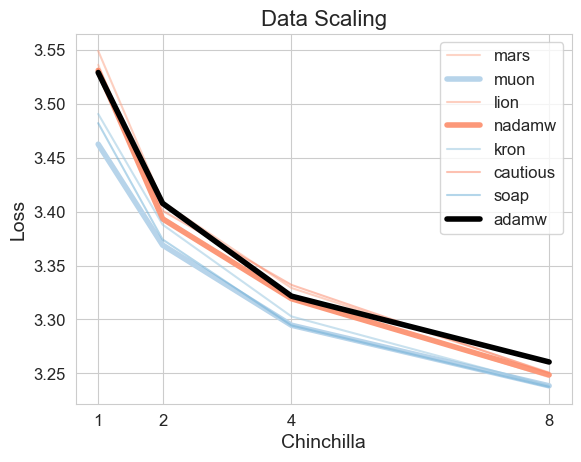

In [6]:
# for each optimizer, plot scaling curve of loss with respect to data size
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
model_size = '130m'

matrix_level = ['kron', 'soap', 'muon']

# add a color map for every optimizer, for matrix level, use color close to blue, for other, use color close to red, but every one has a unique color
color_map = {}
i = 0
j = 0
for optimizer in key_of_optimizer:
    if optimizer in matrix_level:
        color_map[optimizer] = plt.cm.Blues(np.linspace(0.3, 0.5, len(matrix_level)))[i]
        i += 1
    elif optimizer == 'adamw':
        color_map[optimizer] = 'black'
    else:
        color_map[optimizer] = plt.cm.Reds(np.linspace(0.3, 0.5, len(key_of_optimizer) - len(matrix_level)))[j]
        j += 1

plt.rcParams.update({'font.size': 14})  # Increase base font size
sns.set_style("whitegrid")
for optimizer in key_of_optimizer:
    if optimizer in ['scion', 'soape', 'soapb']:
        continue
    optimizer_keys = key_of_optimizer[optimizer]
    data_sizes = ['2B', '5B', '10B', '21B']
    losses_list = []
    for data_size in data_sizes:
        loss = losses.get((optimizer, model_size, data_size), None)
        if loss is not None:
            losses_list.append(loss)
        else:
            losses_list.append(np.nan)
    if optimizer == 'nadamw':
        plt.plot([1,2,4,8], losses_list, label=optimizer, linewidth=4, alpha = 1, color=color_map[optimizer])
    elif optimizer == 'muon':
        plt.plot([1,2,4,8], losses_list, label=optimizer, linewidth=4, alpha = 1, color=color_map[optimizer])
    elif optimizer == 'adamw':
        plt.plot([1,2,4,8], losses_list, label=optimizer, linewidth=4, alpha = 1, color=color_map[optimizer])
    else:
        plt.plot([1,2,4,8], losses_list, label=optimizer, alpha = 0.5, color=color_map[optimizer])
# plt.yscale('log')
# plt.xscale('log')
plt.title('Data Scaling', fontsize=16)
plt.xlabel('Chinchilla', fontsize=14)
plt.ylabel('Loss', fontsize=14)    
plt.xticks([1,2,4,8], ['1', '2', '4', '8'], fontsize=12)
plt.gca().set_xticks([1,2,4,8])  # Only show these x-ticks
plt.gca().set_xticklabels(['1', '2', '4', '8'], fontsize=12)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
#zoom in to 3.3 to 3.35
# plt.ylim(3.26, 3.35)

(array([3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

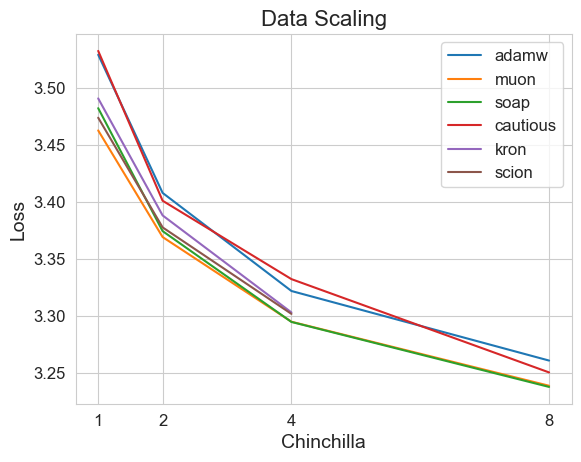

In [48]:
# for each optimizer, plot scaling curve of loss with respect to data size
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
model_size = '130m'

plt.rcParams.update({'font.size': 14})  # Increase base font size
sns.set_style("whitegrid")

for optimizer in ['adamw', 'muon', 'soap', 'cautious', 'kron', 'scion']:
    optimizer_keys = key_of_optimizer[optimizer]
    data_sizes = ['2B', '5B', '10B', '21B']
    losses_list = []
    for data_size in data_sizes:
        loss = losses.get((optimizer, model_size, data_size), None)
        if loss is not None:
            losses_list.append(loss)
        else:
            losses_list.append(np.nan)
    plt.plot([1,2,4,8], losses_list, label=optimizer)
# plt.yscale('log')
# plt.xscale('log')
plt.title('Data Scaling', fontsize=16)
plt.xlabel('Chinchilla', fontsize=14)
plt.ylabel('Loss', fontsize=14)    
plt.xticks([1,2,4,8], ['1', '2', '4', '8'], fontsize=12)
plt.gca().set_xticks([1,2,4,8])  # Only show these x-ticks
plt.gca().set_xticklabels(['1', '2', '4', '8'], fontsize=12)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
#zoom in to 3.3 to 3.35
# plt.ylim(3.26, 3.35)

In [36]:
# delete cautious, 500M
del losses[('cautious', '520m', '10B')]


(array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

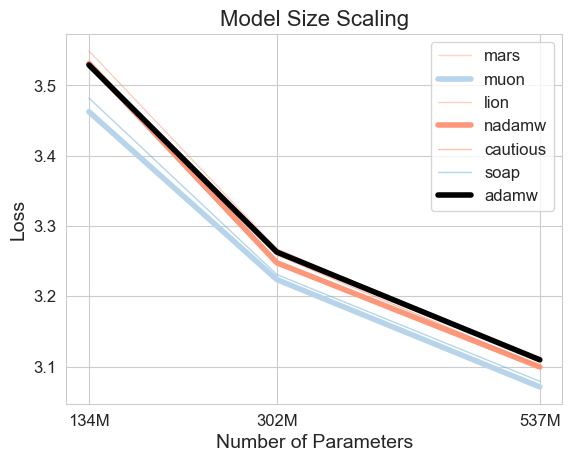

In [7]:
expected_params = {
    "130m": 134217728,    # 32 * (512*2048*3 + 512*512*4)
    "300m": 301989888,    # 32 * (768*3072*3 + 768*768*4)
    "520m": 536870912,    # 32 * (1024*4096*3 + 1024*1024*4)
    "1.2b": 1207959552,   # 32 * (1536*6144*3 + 1536*1536*4)
}

plt.rcParams.update({'font.size': 14})  # Increase base font size
sns.set_style("whitegrid")


matrix_level = ['kron', 'soap', 'muon']

# add a color map for every optimizer, for matrix level, use color close to blue, for other, use color close to red, but every one has a unique color


for optimizer in key_of_optimizer:
    if optimizer in ['scion', 'soape', 'soapb', 'kron']:
        continue
    optimizer_keys = key_of_optimizer[optimizer]
    model_and_data_sizes = [('130m', '2B'), ('300m', '6B'), ('520m', '10B')]
    params = [expected_params[model_size] for model_size, _ in model_and_data_sizes]
    losses_list = []
    for model_size, data_size in model_and_data_sizes:
        loss = losses.get((optimizer, model_size, data_size), None)
        alpha = 1 if optimizer in ['nadamw', 'adamw', 'muon'] else 0.5
        linewidth = 4 if optimizer in ['nadamw', 'muon', 'adamw'] else 1
        if loss is not None:
            losses_list.append(loss)
        else:
            losses_list.append(np.nan)
    plt.plot(params, losses_list, label=optimizer, alpha=alpha, linewidth=linewidth, color=color_map[optimizer])
    # plt.plot(params, losses_list, label=optimizer)
# plt.yscale('log')
# plt.xscale('log')
plt.title('Model Size Scaling', fontsize=16)
plt.xlabel('Number of Parameters', fontsize=14)
plt.ylabel('Loss', fontsize=14)    
plt.xticks(params, [f'{p/1e6:.0f}M' for p in params], fontsize=12)
plt.gca().set_xticks(params)  # Only show these x-ticks
plt.gca().set_xticklabels([f'{p/1e6:.0f}M' for p in params], fontsize=12)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
#zoom in to 3.3 to 3.35
# plt.ylim(3.26, 3.35)

In [6]:
print(losses)

{('soap', '130m', '2B'): 3.4821648597717285, ('adamw', '130m', '2B'): 3.5291428565979004, ('muon', '130m', '2B'): 3.4626309871673584, ('soap', '130m', '5B'): 3.374239921569824, ('adamw', '130m', '5B'): 3.4077868461608887, ('muon', '130m', '5B'): 3.369025468826294, ('soap', '130m', '10B'): 3.294482469558716, ('adamw', '130m', '10B'): 3.3216564655303955, ('muon', '130m', '10B'): 3.2946722507476807, ('soap', '130m', '21B'): 3.2374308109283447, ('adamw', '130m', '21B'): 3.260563611984253, ('muon', '130m', '21B'): 3.238452911376953}


In [24]:
# print config for AdamW across different data sizes and model sizes
data_and_model_sizes = [('130m', '2B'), ('130m', '5B'), ('130m', '10B'), ('130m', '21B'), ('300m', '6B'), ('520m', '10B')]
for optimizer in ['adamw']:
    optimizer_keys = key_of_optimizer[optimizer]
    for model_size, data_size in data_and_model_sizes:
        print(optimizer, model_size, data_size)
        config = configs[(optimizer, model_size, data_size)]
        print(config)

adamw 130m 2B
{'learning_rate': 0.008, 'weight_decay': 0.1, 'min_lr_ratio': 0, 'warmup': 2000, 'beta1': 0.9, 'beta2': 0.98, 'epsilon': 9.999999999999999e-26, 'max_grad_norm': 1, 'nesterov': False, 'train_batch_size': 128}
adamw 130m 5B
{'learning_rate': 0.008, 'weight_decay': 0.1, 'min_lr_ratio': 0, 'warmup': 2000, 'beta1': 0.9, 'beta2': 0.98, 'epsilon': 1e-20, 'max_grad_norm': 2, 'nesterov': False, 'train_batch_size': 128}
adamw 130m 10B
{'learning_rate': 0.008, 'weight_decay': 0.1, 'min_lr_ratio': 0, 'warmup': 2000, 'beta1': 0.9, 'beta2': 0.98, 'epsilon': 1e-20, 'max_grad_norm': 1, 'nesterov': False, 'train_batch_size': 128}
adamw 130m 21B
{'learning_rate': 0.008, 'weight_decay': 0.1, 'min_lr_ratio': 0, 'warmup': 1000, 'beta1': 0.9, 'beta2': 0.98, 'epsilon': 1e-10, 'max_grad_norm': 1, 'nesterov': False, 'train_batch_size': 256}
adamw 300m 6B
{'learning_rate': 0.008, 'weight_decay': 0.1, 'min_lr_ratio': 0, 'warmup': 2000, 'beta1': 0.9, 'beta2': 0.98, 'epsilon': 1e-10, 'max_grad_norm':

In [5]:
# calculate difference between soap and adamw
soap_losses = []
adamw_losses = []
for data_size in data_sizes:
    soap_loss = new_losses[('soap', model_size, data_size)]
    adamw_loss = new_losses[('adamw', model_size, data_size)]
    if soap_loss is not None and adamw_loss is not None:
        soap_losses.append(soap_loss)
        adamw_losses.append(adamw_loss)
    else:
        soap_losses.append(np.nan)
        adamw_losses.append(np.nan)
    diff = np.array(soap_losses) - np.array(adamw_losses)
print(diff)

[-0.08700609 -0.0282352  -0.03951287]


In [1]:
# find all optimizer key which value is not the same for 2B and 20B

def approximate(a, b):
    if type(a) is not float:
        return a == b
    else:
        return abs(a - b) < 1e-25

different_keys = {}
for optimizer in key_of_optimizer:
    different_keys[optimizer] = []
    print(optimizer)
    for key in key_of_optimizer[optimizer]:
        if key != 'train_batch_size':
            if not approximate(configs[(optimizer, model_size, '2B')][key], configs[(optimizer, model_size, '10B')][key]):
                different_keys[optimizer].append(key)
                print(f"key: {key}, 2B: {configs[(optimizer, model_size, '2B')][key]}, 10B: {configs[(optimizer, model_size, '10B')][key]}")
    print("-----------------")

NameError: name 'key_of_optimizer' is not defined

In [18]:
print(configs[('soap', '130m', '10B')])

{'learning_rate': 0.016, 'weight_decay': 0.1, 'min_lr_ratio': 0, 'warmup': 1000, 'beta1': 0.95, 'beta2': 0.99, 'shampoo_beta': 0.98, 'precondition_frequency': 1, 'partition_grads_into_blocks': False, 'block_size': 256, 'epsilon': 1e-15, 'max_grad_norm': 1, 'train_batch_size': 256}
